In [62]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from keras import applications
from keras import optimizers
from keras.models import Sequential, Model

from six.moves import urllib

image_w, image_h = 150, 150


# Data Preparation

In [2]:
def move_file(p_src_dir, p_dst_dir, p_count):
    i = 0
    for filename in tf.io.gfile.listdir(p_src_dir):
        i += 1
        if i > p_count:
            break
        else:
            tf.io.gfile.rename(p_src_dir + '/' + filename, p_dst_dir + '/' + filename)

In [3]:
FLOWERS_DIR = './flower_photos'
FLOWERS_TRAIN_DIR = './flower_photos/train'
FLOWERS_TEST_DIR = './flower_photos/test'
TEST_FRACTION = 0.25

def download_images():
    
    # download TAR file and extract 
    if not os.path.exists(FLOWERS_DIR):
        DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        print('Downloading flower images from %s...' % DOWNLOAD_URL)
        urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
        !tar xfz flower_photos.tgz

    # Setup TRAIN and TEST folders from values of extracted TAR file
    #  1. move original values to TRAIN subfolders
    #  2. create TEST subfolders
    tf.io.gfile.mkdir('./flower_photos/train')
    tf.io.gfile.rename('./flower_photos/daisy', './flower_photos/train/daisy')  
    tf.io.gfile.rename('./flower_photos/dandelion', './flower_photos/train/dandelion')
    tf.io.gfile.rename('./flower_photos/roses', './flower_photos/train/roses')
    tf.io.gfile.rename('./flower_photos/sunflowers', './flower_photos/train/sunflowers')
    tf.io.gfile.rename('./flower_photos/tulips', './flower_photos/train/tulips')
    tf.io.gfile.mkdir('./flower_photos/test')
    tf.io.gfile.mkdir('./flower_photos/test/daisy')
    tf.io.gfile.mkdir('./flower_photos/test/dandelion')
    tf.io.gfile.mkdir('./flower_photos/test/roses')
    tf.io.gfile.mkdir('./flower_photos/test/sunflowers')
    tf.io.gfile.mkdir('./flower_photos/test/tulips')

    # Obtain file counts for each subfolderusing UNIX ls -l command piped to wc -l
    count_daisy = int(os.popen(r"ls -l ./flower_photos/train/daisy/ | wc -l").read()) - 1
    count_dandelion = int(os.popen(r"ls -l ./flower_photos/train/dandelion/ | wc -l").read()) - 1
    count_roses = int(os.popen(r"ls -l ./flower_photos/train/roses/ | wc -l").read()) - 1
    count_sunflowers = int(os.popen(r"ls -l ./flower_photos/train/sunflowers/ | wc -l").read()) - 1
    count_tulips = int(os.popen(r"ls -l ./flower_photos/train/tulips/ | wc -l").read()) - 1
    total_flowers = count_daisy + count_dandelion + count_roses + count_sunflowers + count_tulips
        
    # preserve the same distribution of flower types between train and test datasets
    # Determine number of TRAIN files to move to TEST
    # Using the file counts obtained above, calculate the proporational amount using TEST_FRACTION
    # This ensures both TRAIN and TEST subdirectories will have same distribution of flower types
    target_daisy_test_count = round(TEST_FRACTION * count_daisy,0)
    target_dandelion_test_count = round(TEST_FRACTION * count_dandelion,0)
    target_roses_test_count = round(TEST_FRACTION * count_roses,0)
    target_sunflowers_test_count = round(TEST_FRACTION * count_sunflowers,0)
    target_tulips_test_count = round(TEST_FRACTION * count_tulips,0)

    # Move subset of TRAIN photos to TEST subfolders
    move_file(FLOWERS_TRAIN_DIR + '/daisy', FLOWERS_TEST_DIR + '/daisy', target_daisy_test_count)
    move_file(FLOWERS_TRAIN_DIR + '/dandelion', FLOWERS_TEST_DIR + '/dandelion', target_dandelion_test_count)
    move_file(FLOWERS_TRAIN_DIR + '/roses', FLOWERS_TEST_DIR + '/roses', target_roses_test_count)
    move_file(FLOWERS_TRAIN_DIR + '/sunflowers', FLOWERS_TEST_DIR + '/sunflowers', target_sunflowers_test_count)
    move_file(FLOWERS_TRAIN_DIR + '/tulips', FLOWERS_TEST_DIR + '/tulips', target_tulips_test_count)    
    
    print('Train and Test flower photos are located under %s' % FLOWERS_DIR)

In [4]:
# Commence Data Prep
download_images()

Train and Test flower photos are located under ./flower_photos


In [5]:
# Resize photos to 150 x 150 (image_h x image_w)
# Load train, test photos and their respective classes using ImageDataGenerator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    FLOWERS_TRAIN_DIR,
    # All images will be resized to 150x150 (image_h x image_w)
    target_size=(image_h, image_w),
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    FLOWERS_TEST_DIR,
    target_size=(image_h, image_w),
    batch_size=20,
    class_mode='categorical')

Found 2753 images belonging to 5 classes.
Found 917 images belonging to 5 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 5)


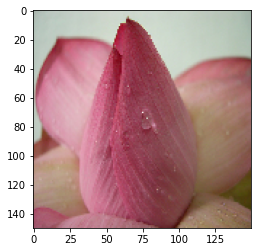

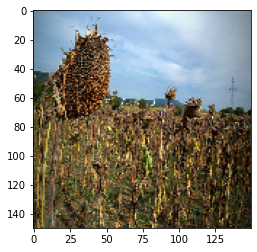

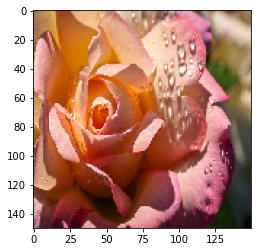

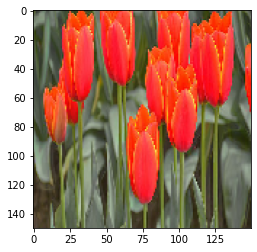

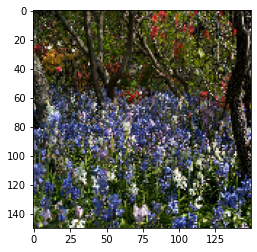

In [7]:
from tensorflow.keras.preprocessing import image
i = 0
for batch in train_generator:
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0][0]))
    i += 1
    #if i % 2 == 0:
    if i == 5:
        break

In [14]:
# VGG16 pre-trained model without fully connected layers 
vgg16 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

# Freeze all layers
for layer in vgg16.layers:
    layer.trainable=False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Model 1

In [15]:
# Adding fully connected layers and some layers create Model 1 
model_1 = Sequential([
    vgg16,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

In [18]:
model_1.compile(loss = "categorical_crossentropy", 
                optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

In [25]:
history_1 = model_1.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 418s 3s/step - loss: 0.8304 - accuracy: 0.6963 - val_loss: 0.6403 - val_accuracy: 0.7721
Epoch 2/20
138/138 [==============================] - 414s 3s/step - loss: 0.7806 - accuracy: 0.7214 - val_loss: 0.6314 - val_accuracy: 0.7852
Epoch 3/20
138/138 [==============================] - 415s 3s/step - loss: 0.7736 - accuracy: 0.7341 - val_loss: 0.6133 - val_accuracy: 0.7895
Epoch 4/20
138/138 [==============================] - 420s 3s/step - loss: 0.7036 - accuracy: 0.7472 - val_loss: 0.6018 - val_accuracy: 0.7928
Epoch 5/20
138/138 [==============================] - 418s 3s/step - loss: 0.6388 - accuracy: 0.7668 - val_loss: 0.5873 - val_accuracy: 0.7895
Epoch 6/20
138/138 [==============================] - 418s 3s/step - loss: 0.6369 - accuracy: 0.7762 - val_loss: 0.5835 - val_accuracy: 0.7928
Epoch 7/20
138/138 [==============================] - 416s 3s/step - loss: 0.5954 - accuracy: 0.7850 - val_loss: 0.5776 - val_accuracy: 0.7950

In [26]:
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


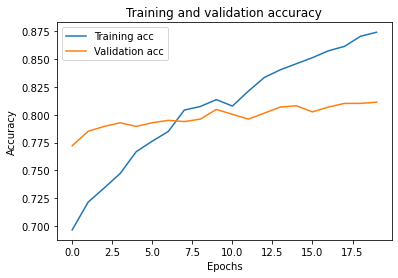

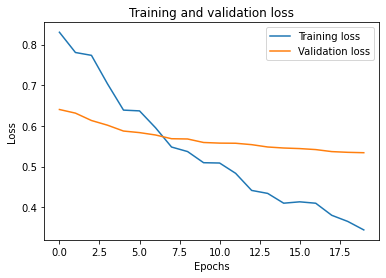

In [35]:
acc      = history_1.history['accuracy']
val_acc  = history_1.history['val_accuracy']
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs   = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [29]:
# Adding fully connected layers and some layers create Model 1 
model_1a = Sequential([
    vgg16,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_1a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

In [117]:
# USE A LARGER LEARNING RATE

model_1a.compile(loss = "categorical_crossentropy", 
                optimizer = optimizers.SGD(lr=0.001, momentum=0.9), 
                metrics=["accuracy"])

# model_1.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics = ['acc'])

In [118]:
history_1a = model_1a.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 412s 3s/step - loss: 0.1216 - accuracy: 0.9586 - val_loss: 0.7923 - val_accuracy: 0.8277
Epoch 2/20
138/138 [==============================] - 410s 3s/step - loss: 0.0849 - accuracy: 0.9677 - val_loss: 0.7941 - val_accuracy: 0.8233
Epoch 3/20
138/138 [==============================] - 410s 3s/step - loss: 0.0901 - accuracy: 0.9662 - val_loss: 0.7928 - val_accuracy: 0.8255
Epoch 4/20
138/138 [==============================] - 416s 3s/step - loss: 0.0831 - accuracy: 0.9688 - val_loss: 0.7859 - val_accuracy: 0.8255
Epoch 5/20
138/138 [==============================] - 416s 3s/step - loss: 0.0853 - accuracy: 0.9699 - val_loss: 0.7864 - val_accuracy: 0.8277
Epoch 6/20
138/138 [==============================] - 411s 3s/step - loss: 0.0752 - accuracy: 0.9742 - val_loss: 0.7904 - val_accuracy: 0.8288
Epoch 7/20
138/138 [==============================] - 410s 3s/step - loss: 0.0881 - accuracy: 0.9724 - val_loss: 0.7858 - val_accuracy: 0.8255

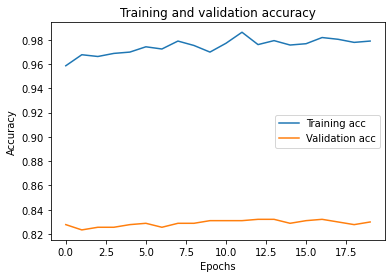

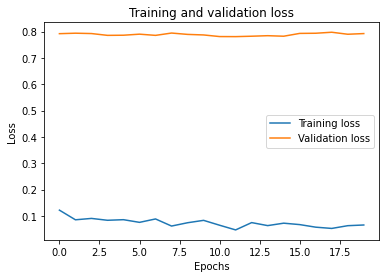

In [119]:
acc      = history_1a.history['accuracy']
val_acc  = history_1a.history['val_accuracy']
loss     = history_1a.history['loss']
val_loss = history_1a.history['val_loss']

epochs   = range(len(acc))


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [37]:
# Adding fully connected layers and some layers create Model 1 
model_1b = Sequential([
    vgg16,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_1b.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)              

In [114]:
# USE A LARGER LEARNING RATE

model_1b.compile(loss = "categorical_crossentropy", 
                optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), 
                metrics=["accuracy"])

# model_1.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics = ['acc'])

In [115]:
history_1b = model_1b.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 411s 3s/step - loss: 0.2137 - accuracy: 0.9303 - val_loss: 0.8044 - val_accuracy: 0.8179
Epoch 2/20
138/138 [==============================] - 409s 3s/step - loss: 0.2427 - accuracy: 0.9248 - val_loss: 0.8059 - val_accuracy: 0.8146
Epoch 3/20
138/138 [==============================] - 414s 3s/step - loss: 0.2064 - accuracy: 0.9306 - val_loss: 0.8115 - val_accuracy: 0.8157
Epoch 4/20
138/138 [==============================] - 404s 3s/step - loss: 0.2131 - accuracy: 0.9317 - val_loss: 0.8056 - val_accuracy: 0.8168
Epoch 5/20
138/138 [==============================] - 422s 3s/step - loss: 0.2253 - accuracy: 0.9303 - val_loss: 0.8027 - val_accuracy: 0.8146
Epoch 6/20
138/138 [==============================] - 417s 3s/step - loss: 0.2172 - accuracy: 0.9346 - val_loss: 0.8024 - val_accuracy: 0.8157
Epoch 7/20
138/138 [==============================] - 412s 3s/step - loss: 0.2114 - accuracy: 0.9346 - val_loss: 0.8061 - val_accuracy: 0.8157

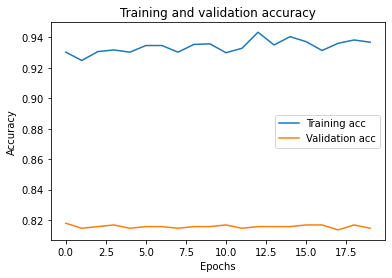

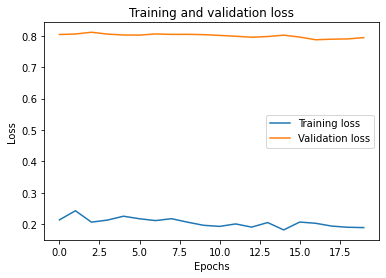

In [116]:
acc      = history_1b.history['accuracy']
val_acc  = history_1b.history['val_accuracy']
loss     = history_1b.history['loss']
val_loss = history_1b.history['val_loss']

epochs   = range(len(acc))


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [41]:
# Adding fully connected layers and some layers create Model 1 
model_1c = Sequential([
    vgg16,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_1c.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)              

In [42]:
# USE ADAM OPTIMIZER

# model_1c.compile(loss = "categorical_crossentropy", 
#                 optimizer = optimizers.SGD(lr=0.09, momentum=0.9), 
#                 metrics=["accuracy"])

model_1c.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics = ['acc'])

In [43]:
history_1c = model_1c.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 415s 3s/step - loss: 1.1615 - acc: 0.6291 - val_loss: 0.6187 - val_acc: 0.7917
Epoch 2/20
138/138 [==============================] - 411s 3s/step - loss: 0.6640 - acc: 0.7799 - val_loss: 0.5363 - val_acc: 0.8201
Epoch 3/20
138/138 [==============================] - 411s 3s/step - loss: 0.4538 - acc: 0.8453 - val_loss: 0.4970 - val_acc: 0.8288
Epoch 4/20
138/138 [==============================] - 412s 3s/step - loss: 0.3599 - acc: 0.8685 - val_loss: 0.5377 - val_acc: 0.8299
Epoch 5/20
138/138 [==============================] - 411s 3s/step - loss: 0.2631 - acc: 0.9066 - val_loss: 0.5237 - val_acc: 0.8353
Epoch 6/20
138/138 [==============================] - 413s 3s/step - loss: 0.2152 - acc: 0.9310 - val_loss: 0.5709 - val_acc: 0.8266
Epoch 7/20
138/138 [==============================] - 410s 3s/step - loss: 0.1406 - acc: 0.9517 - val_loss: 0.5786 - val_acc: 0.8244
Epoch 8/20
138/138 [==============================] - 413s 3s/step - 

In [46]:
print(history_1c.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


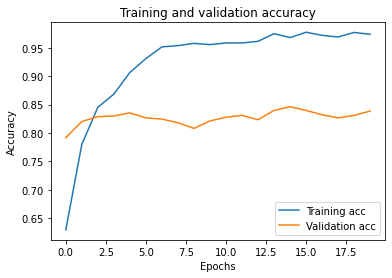

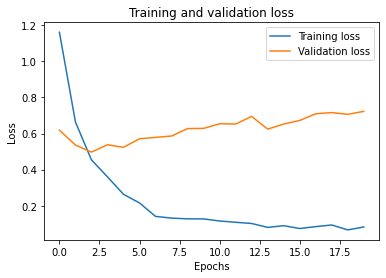

In [47]:
acc      = history_1c.history['acc']
val_acc  = history_1c.history['val_acc']
loss     = history_1c.history['loss']
val_loss = history_1c.history['val_loss']

epochs   = range(len(acc))


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [48]:
# Adding fully connected layers and some layers create Model 1 
model_1d = Sequential([
    vgg16,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_1d.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)              

In [121]:
model_1d.compile(loss = "categorical_crossentropy", 
                optimizer = optimizers.SGD(lr=0.01, momentum=0.9), 
                metrics=["accuracy"])

In [122]:
history_1d = model_1d.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 420s 3s/step - loss: 1.1968 - accuracy: 0.6237 - val_loss: 0.7465 - val_accuracy: 0.7732
Epoch 2/20
138/138 [==============================] - 413s 3s/step - loss: 0.8175 - accuracy: 0.7356 - val_loss: 0.6988 - val_accuracy: 0.7579
Epoch 3/20
138/138 [==============================] - 411s 3s/step - loss: 0.6645 - accuracy: 0.7868 - val_loss: 0.6110 - val_accuracy: 0.7950
Epoch 4/20
138/138 [==============================] - 414s 3s/step - loss: 0.5442 - accuracy: 0.8206 - val_loss: 0.5995 - val_accuracy: 0.7961
Epoch 5/20
138/138 [==============================] - 411s 3s/step - loss: 0.4784 - accuracy: 0.8373 - val_loss: 0.5767 - val_accuracy: 0.8070
Epoch 6/20
138/138 [==============================] - 411s 3s/step - loss: 0.3916 - accuracy: 0.8725 - val_loss: 0.5954 - val_accuracy: 0.7950
Epoch 7/20
138/138 [==============================] - 410s 3s/step - loss: 0.3367 - accuracy: 0.8874 - val_loss: 0.6486 - val_accuracy: 0.8037

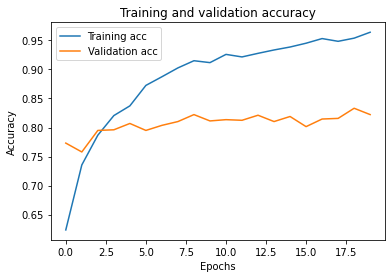

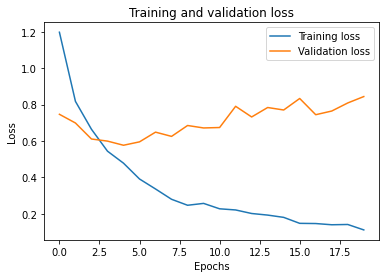

In [123]:
acc      = history_1d.history['accuracy']
val_acc  = history_1d.history['val_accuracy']
loss     = history_1d.history['loss']
val_loss = history_1d.history['val_loss']

epochs   = range(len(acc))


plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [133]:
model_1.evaluate(test_generator)

46/46 [==============================] - 117s 3s/step - loss: 0.5340 - accuracy: 0.8113


[0.5340206623077393, 0.8113413453102112]

In [134]:
model_1a.evaluate(test_generator)

46/46 [==============================] - 103s 2s/step - loss: 0.7927 - accuracy: 0.8299


[0.7926756143569946, 0.8298800587654114]

In [135]:
model_1b.evaluate(test_generator)

46/46 [==============================] - 117s 3s/step - loss: 0.7943 - accuracy: 0.8146


[0.7943480014801025, 0.814612865447998]

In [136]:
model_1c.evaluate(test_generator)

46/46 [==============================] - 106s 2s/step - loss: 0.8848 - acc: 0.8233


[0.8848137259483337, 0.8233369588851929]

In [137]:
model_1d.evaluate(test_generator)

46/46 [==============================] - 104s 2s/step - loss: 0.8439 - accuracy: 0.8222


[0.8439164161682129, 0.8222464323043823]

## The best set of hyperparameters used were found in model_1a.  Here the learning rate was increased slightly from model_1.


# Model 2

In [140]:
# VGG16 pre-trained model without fully connected layers 
vgg16_2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
    
vgg16_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [141]:
# Adding fully connected layers and some layers create Model 1 
model_2 = Sequential([
    vgg16_2,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)              

In [143]:
for i, layer in enumerate(vgg16_2.layers):
    print(i, layer.name, layer.trainable)

0 input_5 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [146]:
# Freezing the layers we don't want to train
for layer in vgg16_2.layers[:14]:
    layer.trainable = False

In [147]:
for i, layer in enumerate(vgg16_2.layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [148]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)              

In [150]:
model_2.compile(loss = "categorical_crossentropy", 
                optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

In [151]:
history_2 = model_2.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 535s 4s/step - loss: 1.9680 - accuracy: 0.3741 - val_loss: 1.9171 - val_accuracy: 0.4068
Epoch 2/20
138/138 [==============================] - 478s 3s/step - loss: 1.3572 - accuracy: 0.5394 - val_loss: 3.3339 - val_accuracy: 0.3293
Epoch 3/20
138/138 [==============================] - 478s 3s/step - loss: 1.3995 - accuracy: 0.5180 - val_loss: 0.8283 - val_accuracy: 0.7077
Epoch 4/20
138/138 [==============================] - 479s 3s/step - loss: 1.0694 - accuracy: 0.6440 - val_loss: 0.6983 - val_accuracy: 0.7677
Epoch 5/20
138/138 [==============================] - 476s 3s/step - loss: 0.9062 - accuracy: 0.6876 - val_loss: 0.8726 - val_accuracy: 0.6761
Epoch 6/20
138/138 [==============================] - 477s 3s/step - loss: 0.8793 - accuracy: 0.7000 - val_loss: 1.8113 - val_accuracy: 0.4318
Epoch 7/20
138/138 [==============================] - 476s 3s/step - loss: 0.8321 - accuracy: 0.7167 - val_loss: 0.5453 - val_accuracy: 0.7928

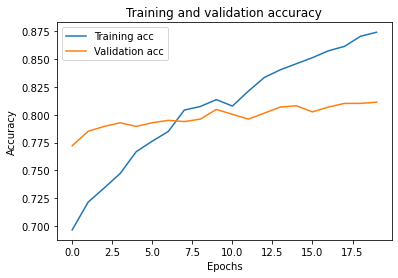

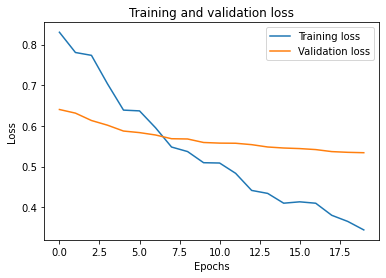

In [152]:
acc      = history_1.history['accuracy']
val_acc  = history_1.history['val_accuracy']
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs   = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 3

In [153]:
vgg16_3 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
    
vgg16_3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [154]:
# Adding fully connected layers and some layers create Model 1 
model_3 = Sequential([
    vgg16_3,
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)              

In [155]:
for i, layer in enumerate(vgg16_3.layers):
    print(i, layer.name, layer.trainable)

0 input_6 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [156]:
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               2097408   
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)              

In [157]:
model_3.compile(loss = "categorical_crossentropy", 
                optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

In [158]:
history_3 = model_3.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=20)

Epoch 1/20
138/138 [==============================] - 1227s 9s/step - loss: 2.3666 - accuracy: 0.2692 - val_loss: 3.1482 - val_accuracy: 0.2279
Epoch 2/20
138/138 [==============================] - 1234s 9s/step - loss: 1.9666 - accuracy: 0.3360 - val_loss: 2.1446 - val_accuracy: 0.3675
Epoch 3/20
138/138 [==============================] - 1228s 9s/step - loss: 2.0192 - accuracy: 0.3273 - val_loss: 135285.5156 - val_accuracy: 0.1788
Epoch 4/20
138/138 [==============================] - 1225s 9s/step - loss: 2.2885 - accuracy: 0.2463 - val_loss: 88731.9844 - val_accuracy: 0.2356
Epoch 5/20
138/138 [==============================] - 1220s 9s/step - loss: 2.2101 - accuracy: 0.2604 - val_loss: 186579.9531 - val_accuracy: 0.3097
Epoch 6/20
138/138 [==============================] - 1222s 9s/step - loss: 2.1431 - accuracy: 0.2692 - val_loss: 352311.1562 - val_accuracy: 0.3501
Epoch 7/20
138/138 [==============================] - 1226s 9s/step - loss: 2.1130 - accuracy: 0.2793 - val_loss: 627

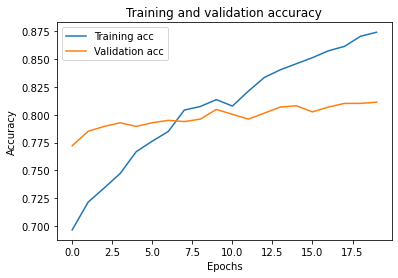

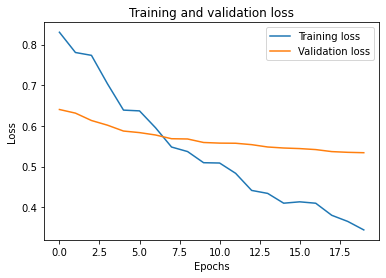

In [159]:
acc      = history_1.history['accuracy']
val_acc  = history_1.history['val_accuracy']
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs   = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [160]:
model_2.evaluate(test_generator)

46/46 [==============================] - 99s 2s/step - loss: 0.5457 - accuracy: 0.8168


[0.5457441210746765, 0.8167939186096191]

In [161]:
model_3.evaluate(test_generator)

46/46 [==============================] - 100s 2s/step - loss: 872075.3125 - accuracy: 0.3261


[872075.3125, 0.32606324553489685]

# Conclusion

The model with all frozen layers (model_1a) is the Best model in terms of accuracy

As soon some of the layers are unfrozen, the model starts to becoming trainable enabling back propogation for a few layers in the model. This results a change in the weights for the 5th Block (model_2) and negatively affects the model accuracy -- although the changes were not drastic (82.99% vs. 81.68% accuracy, and 79.27% vs. 54.57% error)

model_3 eventually turns out to be the worse model with all the layers  trainable.  It would require a lot of data to train the 3rd model in order to achieve a better accuracy given ImageNet is 20 million+ images compared to our small data set (3000 images)


